In [1]:
import os

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import PIL.Image
from tqdm.notebook import tqdm, trange
import glob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from IPython.display import Image as IImage
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
import torch
import clip
from PIL import Image
import base64

import os

In [3]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')


In [4]:
def find_gpus(nums=6):
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp_free_gpus')
    with open('tmp_free_gpus', 'r') as lines_txt:
        frees = lines_txt.readlines()
        idx_freeMemory_pair = [ (idx,int(x.split()[2]))
                              for idx,x in enumerate(frees) ]
    idx_freeMemory_pair.sort(key=lambda my_tuple:my_tuple[1],reverse=True)
    usingGPUs = [str(idx_memory_pair[0])
                    for idx_memory_pair in idx_freeMemory_pair[:nums] ]
    usingGPUs =  ','.join(usingGPUs)
    print('using GPU idx: #', usingGPUs)
    return usingGPUs


## get topics

In [6]:
from bertopic import BERTopic
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
topics = {196: {'traffic', 'pedestrian', 'crossing', 'signal', 'cross', 'stripe', 'crosswalk'}, 412: {'pedestrian', 'walkable', 'walkability', 'walk', 'perp', 'pers', 'arrest'}, 172: {'traffic', 'pedestrian', 'vehicle', 'transportation', 'lane', 'road', 'car', 'street'}, 363: {'stalker', 'witness', 'intervention', 'bystander', 'pedestrian', 'assault', 'stalk', 'intervene', 'victim'}, 198: {'parking', 'tow', 'garage', 'pedestrian', 'park', 'vehicle', 'parkjockey', 'car'}, 114: {'athlete', 'wheelchair', 'pedestrian', 'disability', 'paralympics', 'sport', 'sportspeople', 'paralympic'}, 419: {'suffix', 'manhattan', 'boulevard', 'pedestrian', 'intersection', 'avenue', 'road', 'street'}, 294: {'offence', 'reckless', 'traffic', 'pedestrian', 'speed', 'ticket', 'licence', 'penalty', 'violation', 'drive', 'fine'}, 388: {'brownian', 'pedestrian', 'wiener', 'stochastic', 'markov', 'distribution', 'walk', 'diffusion', 'step', 'percolation'}, 314: {'interchange', 'traffic', 'junction', 'circle', 'pedestrian', 'lane', 'intersection', 'road', 'roundabout'}, 98: {'parking', 'sign', 'traffic', 'signage', 'pedestrian', 'cross', 'lane', 'marker', 'road', 'direction'}, 80: {'fatality', 'collision', 'momentum', 'pedestrian', 'vehicle', 'nhtsa', 'accident', 'drive', 'brake', 'velocity'}, 134: {'edmonton', 'pedestrian', 'ontario', 'gardiner', 'toronto', 'lane', 'expressway', 'avenue', 'highway', 'freeway', 'road'}, 432: {'pulitzer', 'novel', 'pedestrian', 'poem', 'alice', 'fiction', 'book', 'walker', 'poetry'}, 394: {'bridleways', 'path', 'boulevard', 'alley', 'bridleway', 'pedestrian', 'footpath'}, 53: {'pedestrian', 'concrete', 'asphalt', 'gravel', 'pavement', 'pothole', 'pave', 'road', 'cement', 'sand'}, 56: {'transit', 'subway', 'tram', 'pedestrian', 'streetcar', 'transportation', 'train', 'trolley', 'bus'}, 150: {'traffic', 'pedestrian', 'ramp', 'lane', 'highway', 'intersection', 'freeway', 'road'}, 278: {'deck', 'pedestrian', 'promener', 'park', 'promenadef', 'promenade', 'promenaden', 'walk'}, -1: {'street', 'her', 'film', 'century', 'pedestrian', 'example', 'public', 'state', 'water', 'american'}, 43: {'segregation', 'negro', 'protester', 'civil', 'white', 'black', 'pedestrian', 'racial', 'race', 'protest'}, 265: {'hatch', 'carriage', 'diaper', 'child', 'pedestrian', 'harness', 'baby', 'stroller', 'infant'}, 345: {'safety', 'pedestrian', 'guardrail', 'hazard', 'bumper', 'protect', 'rail', 'barrier'}, 378: {'building', 'architecture', 'pedestrian', 'park', 'architect', 'chicago', 'frederick', 'city'}, 11: {'interstate', 'pedestrian', 'terminus', 'lane', 'highway', 'intersection', 'route', 'freeway', 'road', 'turnpike'}, 331: {'scenic', 'pedestrian', 'road', 'highway', 'byway', 'parkway', 'route', 'roadway', 'navajo'}, 202: {'congestion', 'traffic', 'pedestrian', 'vehicle', 'downstream', 'speed', 'congest', 'bottleneck', 'delay', 'road'}, 169: {'homelessness', 'pedestrian', 'home', 'homeless', 'house', 'housing', 'apartment', 'household', 'condominium', 'shelter'}, 327: {'statue', 'bartholdi', 'sculptor', 'pedestrian', 'pedestal', 'monument', 'torch', 'liberty', 'sculpture', 'lazarus'}, 309: {'line', 'railway', 'pedestrian', 'carriageworks', 'adelaide', 'rail', 'train', 'geelong', 'close', 'melbourne'}, 68: {'wagon', 'carriage', 'pedestrian', 'vehicle', 'axle', 'passenger', 'wheel', 'chariot'}, 216: {'m25', 'motorway', 'pedestrian', 'm32', 'lane', 'carriageway', 'm1', 'm11', 'road', 'roundabout'}, 40: {'enforcement', 'pedestrian', 'constabulary', 'constable', 'officer', 'police', 'patrol', 'arrest'}, 99: {'structure', 'building', 'roof', 'construction', 'pedestrian', 'wall', 'concrete', 'masonry', 'insulation'}, 426: {'vanets', 'v2x', '80211p', 'pedestrian', 'vehicle', 'cv2x', 'vehicular', 'vanet', 'unlock', 'v2v'}, 344: {'corniche', 'pedestrian', 'rome', 'censor', 'adriatic', 'itinerary', 'pave', 'road', 'roman'}, 47: {'manhattan', 'subway', 'pedestrian', 'bmt', 'broadway', 'broadwayseventh', 'train', 'avenue', 'brooklyn', 'station'}, 8: {'rider', 'rid', 'bicycle', 'pedestrian', 'cycle', 'cyclist', 'tire', 'bike', 'cycling'}, 416: {'sift', 'detection', 'recognition', 'detector', 'pedestrian', 'descriptor', 'keypoints', 'ocr', 'vision', 'pixel'}, 112: {'congestion', 'traffic', 'transit', 'freight', 'transport', 'pedestrian', 'transportation', 'passenger', 'route', 'bus'}, 137: {'motorway', 'pedestrian', 'lane', 'expressway', 'highway', 'freeway', 'road'}, 441: {'shakespeare', 'character', 'novel', 'pedestrian', 'drama', 'protagonist', 'hamlet', 'actor', 'romeo'}, 192: {'gait', 'symptom', 'diplegia', 'disorder', 'ataxia', 'pedestrian', 'syndrome', 'palsy', 'cerebellum', 'cerebral', 'cerebellar'}, 20: {'dancer', 'foot', 'ankle', 'leg', 'pedestrian', 'toe', 'dance'}, 296: {'area', 'scenic', 'playground', 'wilderness', 'recreation', 'pedestrian', 'park', 'monument', 'yellowstone'}, 144: {'', 'more', 'separate', 'video', 'pedestrian', 'comma', 'share', 'image', 'person', 'address'}, 12: {'hiker', 'path', 'pedestrian', 'trail', 'footpath', 'mountain', 'appalachian', 'hike'}, 224: {'sb', 'transit', 'bus', 'tram', 'fleet', 'pedestrian', 'singapore', 'smrt', 'goahead', 'depot'}, 250: {'umdf', 'driver', 'kernelmode', 'kmdf', 'linux', 'pedestrian', 'printer', 'graphic', 'kernel', 'usb'}, 376: {'charlie', 'snoopy', 'cartoon', 'pedestrian', 'peanut', 'bear', 'trolley', 'lucy', 'mickey', 'disney'}}

In [9]:
# topics = get_topics(concept='aircraft')
q_id = [el for el in topics]

In [10]:
for el in topics:
    print(el, topics[el])

196 {'stripe', 'signal', 'pedestrian', 'crosswalk', 'cross', 'traffic', 'crossing'}
412 {'walkability', 'pers', 'perp', 'walkable', 'pedestrian', 'arrest', 'walk'}
172 {'traffic', 'street', 'transportation', 'car', 'pedestrian', 'road', 'lane', 'vehicle'}
363 {'victim', 'assault', 'intervention', 'intervene', 'stalk', 'witness', 'pedestrian', 'bystander', 'stalker'}
198 {'garage', 'car', 'parking', 'pedestrian', 'tow', 'park', 'parkjockey', 'vehicle'}
114 {'athlete', 'disability', 'paralympic', 'sportspeople', 'pedestrian', 'paralympics', 'sport', 'wheelchair'}
419 {'boulevard', 'street', 'manhattan', 'intersection', 'suffix', 'avenue', 'pedestrian', 'road'}
294 {'ticket', 'penalty', 'violation', 'speed', 'drive', 'pedestrian', 'licence', 'offence', 'traffic', 'reckless', 'fine'}
388 {'percolation', 'diffusion', 'step', 'brownian', 'wiener', 'distribution', 'stochastic', 'pedestrian', 'markov', 'walk'}
314 {'lane', 'circle', 'junction', 'roundabout', 'interchange', 'intersection', 'ped

In [11]:
topics[80]

{'accident',
 'brake',
 'collision',
 'drive',
 'fatality',
 'momentum',
 'nhtsa',
 'pedestrian',
 'vehicle',
 'velocity'}

In [12]:
pg_t = dict()
pg_t['a'] = [68, 112, 56, 224]
pg_t['b'] = [309, 344, 47, -1, 53]
pg_t['c'] = [314, 331, 419, 394]
pg_t['d'] = [98, 196, 202, 294]
pg_t['e'] = [172, 137, 11, 134, 150, 216]
pg_t['f'] = [363, 40, 43]
pg_t['g'] = [441, 376]
pg_t['h'] = [144, 416, 327]
pg_t['i'] = [192, 20, 114]
pg_t['j'] = [345]
pg_t['k'] = [8, 265]
pg_t['l'] = [250, 80, 426]
pg_t['m'] = [169, 99, 378]
pg_t['n'] = [432, 388, 412]
pg_t['o'] = [12, 278, 198, 296] 

In [13]:
for el in pg_t:
    group_words = []
    for t in pg_t[el]:
        group_words.extend(list(topics[t]))
#         break
    pg_t[el]= list(set(group_words))
    

In [14]:
print(pg_t[el])

['mountain', 'monument', 'trail', 'area', 'promenaden', 'tow', 'recreation', 'walk', 'promener', 'promenadef', 'garage', 'playground', 'pedestrian', 'yellowstone', 'park', 'vehicle', 'car', 'parking', 'appalachian', 'path', 'wilderness', 'promenade', 'hike', 'deck', 'scenic', 'hiker', 'footpath', 'parkjockey']


In [15]:
for g in pg_t:
    pg_t[g] = ' '.join(pg_t[g])

In [16]:
pg_t[g]

'promenaden playground appalachian area scenic trail hike promenade wilderness promenadef parking park footpath path parkjockey deck garage promener recreation yellowstone pedestrian monument walk mountain car vehicle tow hiker'

In [16]:
toopic_dict = dict()
for el in topics:
    toopic_dict[el] = ' '.join(topics[el])
toopic_dict[el]

'mickey disney trolley snoopy bear charlie pedestrian lucy cartoon peanut'

In [17]:
pg_t['a']

'fleet train streetcar freight congestion route carriage sb bus wheel transit pedestrian vehicle tram smrt depot transportation singapore goahead wagon chariot transport trolley subway passenger traffic axle'

## Load Predictions

In [13]:
root_path = '/home/hamed/projects/datasets'
base_path = '.'
#base
df_b = pd.read_pickle(f'{base_path}/pd_base.pk')

# after q50_over_avg
d_path = 'ped_data/ped_fatemeh/missed_q50_over_avg'
df_f = pd.read_pickle(f'{root_path}/{d_path}/pd_mq50_over_avg.pk')

# wit
d_path = 'ped_data/wit/missed_q50_over_avg'
df_w = pd.read_pickle(f'{root_path}/{d_path}/ped_mq50_over_avg.pk')

# random
d_path = 'ped_data/wit/random_missed'
df_r = pd.read_pickle(f'{root_path}/{d_path}/ped_mq50_over_avg.pk')

In [14]:
# Function to calculate average of concept2caption_sim
def calculate_average_concept2caption_sim(df):
    return df['concept2caption_sim'].mean()



In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute the cosine similarity between ofa_caption and a fixed concept
def compute_similarity(ofa_caption, concept):
    # Encode the ofa_caption and concept using the model
    ofa_embedding = model.encode(ofa_caption)
    concept_embedding = model.encode(concept)
    
    # Compute the cosine similarity between the two embeddings
    similarity = cosine_similarity([ofa_embedding], [concept_embedding])[0][0]
    return similarity


In [24]:


# Function to update the concept2caption_sim column in the dataframe
def update_concept2topic_sim(df):
    similarities = []
    for index, row in df.iterrows():
        ofa_caption = row['ofa_caption']
        gt = row['gt']
        
        # Compute similarity and store it
        similarity = compute_similarity(ofa_caption, gt)
        similarities.append(similarity)
    
    # Update the 'concept2caption_sim' column with the newly calculated similarities
    df['concept2caption_sim'] = similarities
    return df

In [16]:

# Function to update the concept2caption_sim column in the dataframe
def update_concept2caption_sim(df, concept= "pedestrian"):
    similarities = []
    for index, row in df.iterrows():
        ofa_caption = row['ofa_caption']
        
        # Compute similarity using the provided concept
        similarity = compute_similarity(ofa_caption, concept)
        similarities.append(similarity)
    
    # Update the 'concept2caption_sim' column with the newly calculated similarities
    df['concept2caption_sim'] = similarities
    return df

# Example usage for updating concept2caption_sim with a fixed concept like "pedestrian"
concept = "pedestrian"  # Replace with "aircraft" or other concepts as needed

In [8]:
# Function to update the cap2cap column in the dataframe
def update_cap2cap_sim(df):
    similarities = []
    for index, row in df.iterrows():
        ofa_caption = row['ofa_caption']
        caption = row['caption']  # Use the 'caption' column for comparison
        
        # Compute similarity and store it
        similarity = compute_similarity(ofa_caption, caption)
        similarities.append(similarity)
    
    # Create and update the 'cap2cap' column with the newly calculated similarities
    df['cap2cap'] = similarities
    return df

# Example usage


In [17]:
# Update each DataFrame
df_b = update_concept2caption_sim(df_b)
df_f = update_concept2caption_sim(df_f)
df_w = update_concept2caption_sim(df_w)
df_r = update_concept2caption_sim(df_r)
# Calculate averages
avg_base = calculate_average_concept2caption_sim(df_b)
avg_fatemeh = calculate_average_concept2caption_sim(df_f)
avg_wit = calculate_average_concept2caption_sim(df_w)
avg_random = calculate_average_concept2caption_sim(df_r)

# Data for plotting
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]



In [9]:
# Function to calculate average of concept2caption_sim
def calculate_average_col_sim(df, col='concept2caption_sim'):
    return df[f'{col}'].mean()

In [10]:
df_b = update_cap2cap_sim(df_b)  # Apply to your dataframe
df_f = update_cap2cap_sim(df_f)
df_w = update_cap2cap_sim(df_w)
df_r = update_cap2cap_sim(df_r)

avg_base = calculate_average_col_sim(df_b, 'cap2cap')
avg_fatemeh = calculate_average_col_sim(df_f, 'cap2cap')
avg_wit = calculate_average_col_sim(df_w, 'cap2cap')
avg_random = calculate_average_col_sim(df_r, 'cap2cap')
# Data for plotting
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]



# Create a dictionary to form a DataFrame
data = {'datasets': datasets, 'averages': averages}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = './data/caption2caption_sim_averages_ped.csv'
df.to_csv(csv_file_path, index=False)

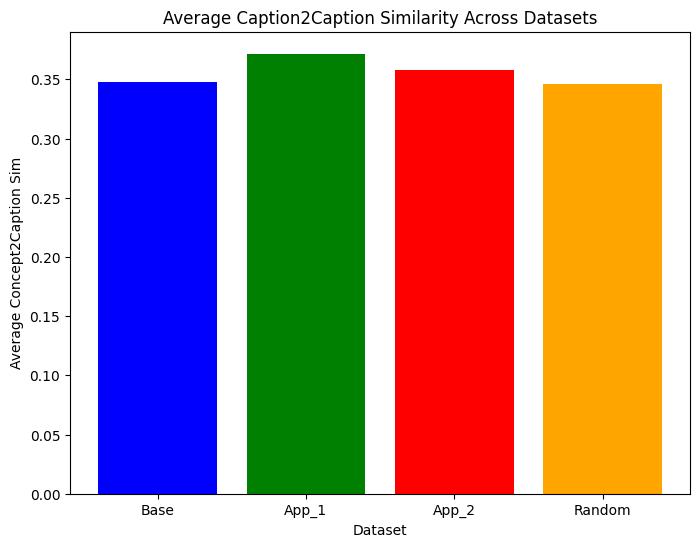

In [49]:
# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(datasets, averages, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Average Concept2Caption Sim')
plt.title('Average Caption2Caption Similarity Across Datasets')
plt.show()

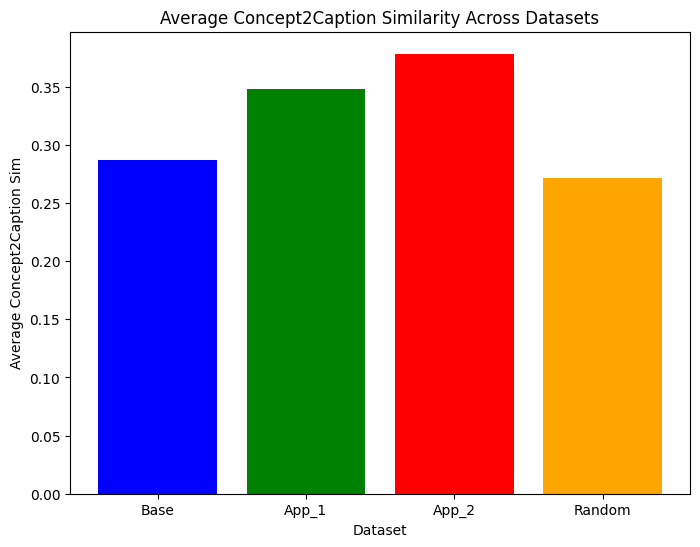

In [35]:
# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(datasets, averages, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Average Concept2Caption Sim')
plt.title('Average Concept2Caption Similarity Across Datasets')
plt.show()

In [18]:
# Define datasets and averages
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]

# Create a dictionary to form a DataFrame
data = {'datasets': datasets, 'averages': averages}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = './data/concept2caption_sim_averages_ped.csv'
df.to_csv(csv_file_path, index=False)

In [13]:
# Function to count the number of tags with a value of 1
def count_tags_with_value_1(tag_dict):
    return sum(value == 1 for value in tag_dict.values())

In [14]:
tag_counts = df_b['tag'].apply(count_tags_with_value_1)
average_tag_count = tag_counts.mean()
average_tag_count

4.406451612903226

In [4]:
len(df_r)

620

In [120]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to calculate semantic accuracy along with precision, recall, F1
def calculate_semantic_metrics(df, threshold=0.5):
    tp_list = []
    fp_list = []
    fn_list = []

    for index, row in df.iterrows():
        gt_concepts = row['gt'].split() if row['gt'] else []  # Ground-truth concepts
        caption_concepts = row['ofa_caption'].split() if row['ofa_caption'] else []  # Generated caption concepts

        # Skip if either gt_concepts or caption_concepts is empty
        if not gt_concepts or not caption_concepts:
            continue

        # Get embeddings for both sets of concepts
        gt_embeddings = model.encode(gt_concepts)
        caption_embeddings = model.encode(caption_concepts)

        # Calculate cosine similarity between gt and caption concepts
        if len(gt_embeddings) > 0 and len(caption_embeddings) > 0:
            similarity_matrix = cosine_similarity(gt_embeddings, caption_embeddings)

            # Check if the max similarity between any gt-concept and caption-concept exceeds the threshold
            tp = 0
            for i in range(len(gt_concepts)):
                if np.max(similarity_matrix[i]) >= threshold:
                    tp += 1

            # False positives: caption concepts not similar to any gt concept
            fp = len(caption_concepts) - tp

            # False negatives: gt concepts not matched by any caption concept
            fn = len(gt_concepts) - tp

            tp_list.append(tp)
            fp_list.append(fp)
            fn_list.append(fn)

    # Compute Precision, Recall, F1 score
    precision = sum(tp_list) / (sum(tp_list) + sum(fp_list)) if (sum(tp_list) + sum(fp_list)) > 0 else 0
    recall = sum(tp_list) / (sum(tp_list) + sum(fn_list)) if (sum(tp_list) + sum(fn_list)) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Compute Accuracy
    accuracy = sum(tp_list) / (sum(tp_list) + sum(fp_list) + sum(fn_list)) if (sum(tp_list) + sum(fp_list) + sum(fn_list)) > 0 else 0

    return precision, recall, f1, accuracy

In [121]:
calculate_semantic_metrics(df_f)

(0.26047192244375345,
 0.5219941348973607,
 0.34752898108602803,
 0.21030866932506276)

In [21]:
# show row 0 of df_r
df_r.iloc[0]

uniq_id                                                              167
image_id                                                             167
caption                             Car on rural road vector Stock Photo
topic_id                                                              68
labels                                                                  
image                  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
topic2caption_sim                                               0.376758
concept2caption_sim                                             0.212455
topics                                                                 a
tag                    {'passenger': 0, 'wheel': 1, 'vehicle': 1, 'wa...
gt                                                         wheel vehicle
h_caption                                  A parked car in a remote area
ofa_caption                   English picture of a car in black and blue
Name: 0, dtype: object

In [131]:
pedestrian_synonym = ['pedestrian', 'passenger', 'person', 'cyclist', 'walker', 'bystander', 'officer', 
                      'protester', 'stalker', 'hiker', 'driver', 'baby', 'child', 'infant', 'actor', 
                      'protagonist', 'victim', 'witness', 'patrol', 'civilian', 'police', 
                      'athlete', 'sportspeople', 'character', 'protest', 'protester', 
                      'protagonist']
pedestrian_synonym = ['pedestrian']
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [77]:
# Function to calculate semantic metrics for a specified set of concept synonyms
def calculate_semantic_metrics_for_synonyms(df, synonym_list, synonym_name, threshold=0.75, use_exact_match=False):
    """
    Args:
        df (pd.DataFrame): The input dataframe containing 'tag' and 'ofa_caption' columns.
        synonym_list (list): A list of synonyms related to a specific concept (e.g., pedestrian synonyms).
        synonym_name (str): The name of the concept synonym group (e.g., 'Pedestrian').
        threshold (float): The similarity threshold for matching ground-truth concepts with generated caption concepts.
        use_exact_match (bool): If True, use exact match instead of cosine similarity for concept matching.

    Returns:
        tuple: Accuracy, precision, recall, and F1 score for the specified concept.
    """
    tp_total, fp_total, fn_total = 0, 0, 0

    for index, row in df.iterrows():
        # Extract ground-truth concepts from the tag that match the provided synonyms
        gt_concepts = [key for key in row['tag'] if key in synonym_list and row['tag'][key] == 1]
        
        # Extract generated caption concepts that match the provided synonyms
        caption_concepts = [word for word in row['ofa_caption'].split() if word in synonym_list]

        # Skip if either gt_concepts or caption_concepts is empty
        if not gt_concepts or not caption_concepts:
            continue

        if use_exact_match:
            # Use exact match
            tp = len(set(gt_concepts).intersection(set(caption_concepts)))
            fp = len(set(caption_concepts) - set(gt_concepts))
            fn = len(set(gt_concepts) - set(caption_concepts))
        else:
            # Use cosine similarity matching
            # Get embeddings for both sets of related concepts
            gt_embeddings = model.encode(gt_concepts)
            caption_embeddings = model.encode(caption_concepts)

            # Calculate cosine similarity between gt and caption concepts
            similarity_matrix = cosine_similarity(gt_embeddings, caption_embeddings)

            # True Positives: Matched ground truth concepts that are correctly predicted
            tp = sum(1 for i in range(len(gt_concepts)) if np.max(similarity_matrix[i]) >= threshold)

            # False Negatives: Ground truth concepts not matched by any caption concept
            fn = len(gt_concepts) - tp

            # False Positives: Caption concepts not similar to any ground truth concept
            unmatched_caption_concepts = [i for i in range(len(caption_concepts)) if np.max(similarity_matrix[:, i]) < threshold]
            fp = len(unmatched_caption_concepts)

        # Update totals
        tp_total += tp
        fp_total += fp
        fn_total += fn

    # Compute Precision, Recall, F1 score
    precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
    recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Compute Accuracy: Correct predictions over all predictions
    accuracy = tp_total / (tp_total + fp_total + fn_total) if (tp_total + fp_total + fn_total) > 0 else 0

    return accuracy, precision, recall, f1

In [133]:
# Use exact match
result_df_base_exact = calculate_semantic_metrics_for_synonyms(df_b, pedestrian_synonym, 'Pedestrian', use_exact_match=True)
result_df_random_exact = calculate_semantic_metrics_for_synonyms(df_r, pedestrian_synonym, 'Pedestrian', use_exact_match=True)
result_df_app1_exact = calculate_semantic_metrics_for_synonyms(df_f, pedestrian_synonym, 'Pedestrian', use_exact_match=True)
result_df_app2_exact = calculate_semantic_metrics_for_synonyms(df_w, pedestrian_synonym, 'Pedestrian', use_exact_match=True)

# Use similarity match (cosine similarity)
result_df_base_sim = calculate_semantic_metrics_for_synonyms(df_b, pedestrian_synonym, 'Pedestrian', use_exact_match=False)
result_df_random_sim = calculate_semantic_metrics_for_synonyms(df_r, pedestrian_synonym, 'Pedestrian', use_exact_match=False)
result_df_app1_sim = calculate_semantic_metrics_for_synonyms(df_f, pedestrian_synonym, 'Pedestrian', use_exact_match=False)
result_df_app2_sim = calculate_semantic_metrics_for_synonyms(df_w, pedestrian_synonym, 'Pedestrian', use_exact_match=False)


In [134]:
# Output the results for each model
print("Base Metrics (Exact):", result_df_base_exact)
print("Random Metrics (Exact):", result_df_random_exact)
print("App_1 Metrics (Exact):", result_df_app1_exact)
print("App_2 Metrics (Exact):", result_df_app2_exact)

Base Metrics (Exact): (1.0, 1.0, 1.0, 1.0)
Random Metrics (Exact): (1.0, 1.0, 1.0, 1.0)
App_1 Metrics (Exact): (1.0, 1.0, 1.0, 1.0)
App_2 Metrics (Exact): (1.0, 1.0, 1.0, 1.0)


In [135]:
print("Base Metrics (Similarity):", result_df_base_sim)
print("Random Metrics (Similarity):", result_df_random_sim)
print("App_1 Metrics (Similarity):", result_df_app1_sim)
print("App_2 Metrics (Similarity):", result_df_app2_sim)

Base Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
Random Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
App_1 Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
App_2 Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)


In [63]:
# Function to group by topics and calculate metrics for each topic
def calculate_metrics_per_topic(df, threshold=0.7):
    results = []
    grouped = df.groupby('topics')
    
    for topic, group in grouped:
        precision, recall, f1, accuracy = calculate_semantic_metrics(group, threshold)
        results.append({
            'topic': topic,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy
        })
    
    return pd.DataFrame(results)

In [64]:
# Calculate metrics per topic
results_df = calculate_metrics_per_topic(df_b, threshold=0.7)
results_df

,topic,precision,recall,f1,accuracy
0,a,0.083503,0.160784,0.109920,0.058156
1,b,0.090628,0.217822,0.128000,0.068376
2,c,0.103131,0.266667,0.148738,0.080344
3,d,0.182906,0.409962,0.252955,0.144790
4,e,0.210643,0.452381,0.287443,0.167845
5,f,0.071895,0.113402,0.088000,0.046025
6,g,0.019920,0.086207,0.032362,0.016447
7,h,0.070632,0.250000,0.110145,0.058282
8,i,0.066176,0.137195,0.089286,0.046729
9,j,0.086957,0.115385,0.099174,0.052174


# AirCraft

In [19]:
root_path = '/home/hamed/projects/datasets'
base_path = '.'
#base
df_b = pd.read_pickle(f'{base_path}/av_base.pk')

# after q50_over_avg
d_path = 'av_data/fatemeh/missed_q50_over_avg'
df_f = pd.read_pickle(f'{root_path}/{d_path}/av_mq50_over_avg.pk')

# wit
d_path = 'av_data/wit/missed_q50_over_avg'
df_w = pd.read_pickle(f'{root_path}/{d_path}/av_mq50_over_avg.pk')

# random
d_path = 'av_data/wit/random_missed'
df_r = pd.read_pickle(f'{root_path}/{d_path}/av_mq50_over_avg.pk')

In [20]:
# Update each DataFrame
df_b = update_concept2caption_sim(df_b, concept='aircraft')
df_f = update_concept2caption_sim(df_f, concept='aircraft')
df_w = update_concept2caption_sim(df_w, concept='aircraft')
df_r = update_concept2caption_sim(df_r, concept='aircraft')
# Calculate averages
avg_base = calculate_average_concept2caption_sim(df_b)
avg_fatemeh = calculate_average_concept2caption_sim(df_f)
avg_wit = calculate_average_concept2caption_sim(df_w)
avg_random = calculate_average_concept2caption_sim(df_r)

# Data for plotting
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]

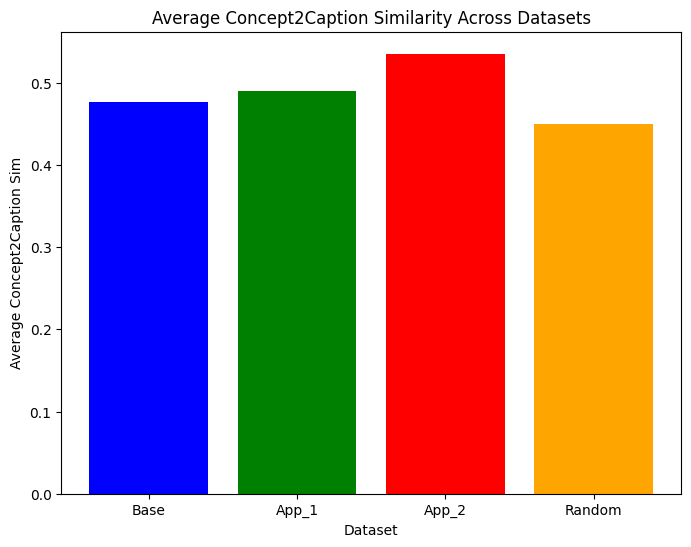

In [39]:
# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(datasets, averages, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Average Concept2Caption Sim')
plt.title('Average Concept2Caption Similarity Across Datasets')
plt.show()

In [12]:
df_b = update_cap2cap_sim(df_b)  # Apply to your dataframe
df_f = update_cap2cap_sim(df_f)
df_w = update_cap2cap_sim(df_w)
df_r = update_cap2cap_sim(df_r)

avg_base = calculate_average_col_sim(df_b, 'cap2cap')
avg_fatemeh = calculate_average_col_sim(df_f, 'cap2cap')
avg_wit = calculate_average_col_sim(df_w, 'cap2cap')
avg_random = calculate_average_col_sim(df_r, 'cap2cap')
# Data for plotting
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]



# Create a dictionary to form a DataFrame
data = {'datasets': datasets, 'averages': averages}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = './data/caption2caption_sim_averages_air.csv'
df.to_csv(csv_file_path, index=False)

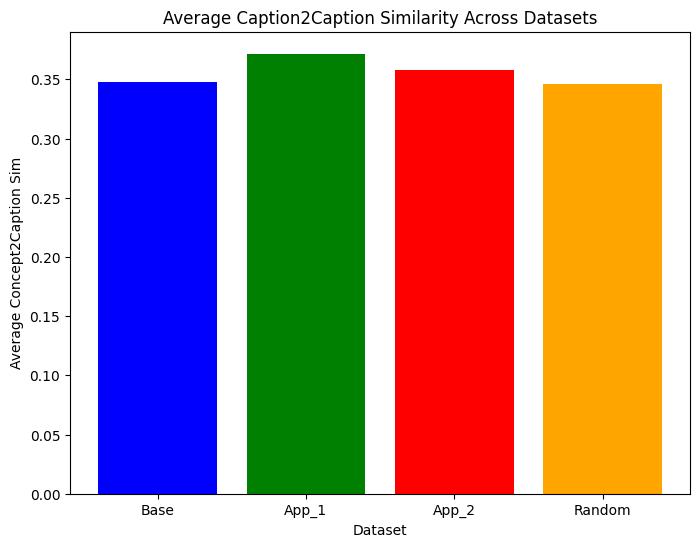

In [52]:
# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(datasets, averages, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Average Concept2Caption Sim')
plt.title('Average Caption2Caption Similarity Across Datasets')
plt.show()

In [21]:
# Define datasets and averages
datasets = ['Base', 'App_1', 'App_2', 'Random']
averages = [avg_base, avg_fatemeh, avg_wit, avg_random]

# Create a dictionary to form a DataFrame
data = {'datasets': datasets, 'averages': averages}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = './data/concept2caption_sim_averages_air.csv'
df.to_csv(csv_file_path, index=False)

In [16]:
tag_counts = df_b['tag'].apply(count_tags_with_value_1)
average_tag_count = tag_counts.mean()
average_tag_count

5.038684719535784

In [7]:
len(df_r)

517

In [123]:
topics = {63: {'airplane', 'fly', 'wing', 'aircraft', 'aviation', 'fuselage', 'aerodynamic', 'plane'}, 3: {'flew', 'fly', 'pilot', 'squadron', 'aviation', 'aircraft', 'lindbergh', 'flight', 'fighter'}, 271: {'licensing', 'airport', 'fly', 'pilot', 'airspace', 'aircraft', 'aerial', 'aviation', 'aerodrome', 'icao', 'flight'}, 145: {'airline', 'boeing', 'airport', 'superjet', 'aircraft', 'aerosvit', 'aeroflots', 'aeroflot', 'flight', 'volgadnepr'}, 298: {'airline', 'shareholders13', 'remuneration', 'pilot', 'aircraft', 'aviation', 'openairplane', 'stakeholder', 'corporate'}, 11: {'airline', 'southwest', 'boeing', 'airport', 'airliner', 'airbus', 'aircraft', 'passenger', 'flight', 'lufthansa'}, 45: {'navy', 'bomber', 'wing', 'squadron', 'aircraft', 'fuselage', 'armament', 'corsair', 'fighter'}, 201: {'aeronautics', 'balloon', 'rocket', 'fly', 'spacecraft', 'aerobraking', 'aircraft', 'spaceflight', 'aerodynamic', 'glide', 'aerobot'}, 35: {'wing', 'beech', 'cessna', 'gear', 'aircraft', 'cabin', 'beechcraft', '1900d', 'engine', 'skyhawk'}, 108: {'biplane', 'design', 'monoplane', 'strut', 'sesquiplane', 'wing', 'cantilever', 'aircraft', 'fuselage'}, 58: {'737', 'airline', '747', 'boeing', '747400', 'freighter', 'airliner', 'aircraft', 'boeings', '7478', '747400s'}, 144: {'1943', 'vengeance', 'bomber', 'raf', 'aircraft', 'squadron', '1944', 'armament', 'v72'}, 157: {'balloon', 'reconnaissance', 'bomber', 'camera', 'aircraft', 'aerial', 'photography', 'photographic'}, 186: {'biplane', 'strut', 'wing', 'aircraft', 'fuselage', 'armament', 'mercedes', 'diii', 'benz', 'albatros'}, 230: {'pylon', 'equipment', 'helicopter', 'aircraft', 'payload', 'carry', 'cargo', 'airlift', 'transport', 'airlifters'}, 159: {'beaufort', 'supermarine', 'pilot', 'beauforts', 'raf', 'aircraft', 'fuselage', 'squadron', 'spitfire'}, 220: {'airline', 'aircraft', 'hijacker', '911', 'pentagon', 'hijack', 'tower', 'plane', 'flight', 'faa'}, 77: {'airline', 'boeing', 'toronto', 'airport', 'fleet', 'aircraft', 'vancouver', 'westjet', 'flight', 'calgary'}, 256: {'airline', 'digit', 'airport', 'aircraft', 'code', 'flight', 'number'}, 104: {'biplane', 'fit', 'fighter', '1916', 'fly', 'wing', 'raf', 'aircraft', 'engine', 'argosy'}, 86: {'airline', 'fiji', 'boeing', 'airport', 'sydney', 'qantas', 'aircraft', 'airway', 'pacific', 'flight'}, 2: {'airline', 'cockpit', 'crashed', 'crash', 'pilot', 'investigator', 'aircraft', 'crew', 'passenger', 'wreckage'}, 34: {'airline', 'airport', 'federal', 'amend', 'legislation', 'aircraft', 'administration', 'aviation', 'tsa'}, 247: {'cockpit', 'pilot', 'aircraft', 'gunner', 'panel', 'control', 'display', 'instrument'}, 23: {'flew', 'fly', 'pilot', 'aviation', 'aircraft', 'woman', 'flight', 'amelia'}, 80: {'spaceplane', 'rocket', 'spacecraft', 'aircraft', 'aerodynamic', 'hypersonic', 'lift', 'land', 'shuttle', 'flight'}, 165: {'hampdens', 'design', 'bomber', 'built', 'prototype', 'wing', 'raf', 'aircraft', 'fuselage', 'patent', 'bluebird'}, 32: {'seaplane', 'flyingboat', 'aircraft', 'floatplane', 'ship', 'naval', 'boat'}, 319: {'aeronautics', 'design', 'ice', 'engineer', 'aircraft', 'pyrodyne', 'engineering', 'hypersonic', 'aeronautical', 'rodert', 'langley'}, 126: {'circadian', 'fly', 'pilot', 'fatigue', 'aircraft', 'phobia', 'fear', 'anxiety', 'flight', 'aviophobia'}, 66: {'clearance', 'airport', 'radar', 'atc', 'airspace', 'pilot', 'aircraft', 'controller', 'flight', 'faa'}, 225: {'boeing', 'supplier', 'airbus', 'aircraft', 'merger', 'aerospace', 'bombardier', 'company', 'industry'}, 25: {'luftwaffe', 'bomber', 'bombing', 'pilot', 'raf', 'aircraft', 'combat', '1944', 'fighter'}, 8: {'fly', 'deployed', 'raf', 'aircraft', 'squadron', 'mission', 'airlift', 'operational', 'airfield'}, 235: {'737', 'airline', 'boeing', '737ng', 'aircraft', 'fuselage', '737800', '737700', '737s', 'boeings', 'southwest'}, 295: {'airline', 'boeing', 'airbus', 'airasia', 'aircraft', 'malaysia', 'kuala', 'malaysian', 'lumpur', 'brunei'}, 227: {'airline', 'charter', 'boeing', 'fleet', 'cargolux', 'aircraft', 'amazon', 'cargo', 'ati'}, 44: {'design', 'luftwaffe', 'bomber', 'wing', 'messerschmitt', 'ju', 'aircraft', 'fuselage', 'armament', 'engine'}, 234: {'bomber', 'hornet', 'raf', 'aircraft', 'squadron', '1944', 'havilland', 'mosquito'}, 50: {'dh60', 'dhc', 'fly', 'canadian', 'aircraft', 'fuselage', 'havilland', 'otter', 'moth'}, 251: {'superjet', 'airliner', 'jet', 'tu204', 'aircraft', 'il214', 'mig35', 'su35s', 'uac', 'company', 'uacs'}, 31: {'dji', 'unmanned', 'sensor', 'reconnaissance', 'aircraft', 'aerial', 'uas', 'uav', 'uavs', 'drone'}, 10: {'airline', 'airport', 'county', 'facility', 'aircraft', 'flight', 'runway', 'airfield'}, 258: {'husky', 'monoplane', 'aircraft', 'fuselage', 'h47', 'airway', 'cabin', 'rcaf', 'h45', 'fairchild'}, 72: {'aviationrelated', '1942', 'event', '1942nd', 'aircraft', 'aviation', 'aerospace4', 'huntsville', 'birmingham', '1910', 'year'}, 93: {'aeronautics', 'mechanical', 'optimization', 'engineer', 'aircraft', 'aviation', 'engineering', 'aerospace', 'aeronautical', 'flight'}, 118: {'airline', 'bcals', 'bua', 'aircraft', 'airway', 'gatwick', 'london', 'flight', 'heathrow', 'bcal'}, 19: {'sailplane', 'wing', 'glider', 'aircraft', 'glide', 'kite', 'soar'}, 139: {'navy', 'cessna', 'refuel', 'usaf', 'aircraft', 'a37', 'training', 'a37b', 't33', 'trainer', 't37'}, 237: {'operation', 'operate', 'copilot', 'pilot', 'aircraft', 'crew', 'captain', 'officer', 'duty', 'faa', 'pilotincommand'}}

In [124]:
print(topics)

{63: {'wing', 'aircraft', 'airplane', 'aerodynamic', 'fuselage', 'fly', 'aviation', 'plane'}, 3: {'squadron', 'lindbergh', 'aircraft', 'fighter', 'pilot', 'flew', 'flight', 'fly', 'aviation'}, 271: {'aircraft', 'pilot', 'icao', 'aerodrome', 'airspace', 'aerial', 'airport', 'flight', 'licensing', 'fly', 'aviation'}, 145: {'aircraft', 'aerosvit', 'aeroflots', 'aeroflot', 'volgadnepr', 'boeing', 'airport', 'flight', 'airline', 'superjet'}, 298: {'stakeholder', 'aircraft', 'remuneration', 'pilot', 'openairplane', 'shareholders13', 'airline', 'aviation', 'corporate'}, 11: {'aircraft', 'airliner', 'boeing', 'airport', 'airbus', 'southwest', 'flight', 'airline', 'passenger', 'lufthansa'}, 45: {'wing', 'squadron', 'aircraft', 'navy', 'fighter', 'bomber', 'fuselage', 'corsair', 'armament'}, 201: {'aircraft', 'aerodynamic', 'aerobot', 'balloon', 'glide', 'fly', 'spaceflight', 'spacecraft', 'aeronautics', 'aerobraking', 'rocket'}, 35: {'wing', 'aircraft', 'beech', 'cabin', 'gear', 'engine', 'beec

In [125]:
# topics = get_topics(concept='aircraft')
q_id = [el for el in topics]

In [126]:
for el in topics:
    print(el, topics[el])

63 {'wing', 'aircraft', 'airplane', 'aerodynamic', 'fuselage', 'fly', 'aviation', 'plane'}
3 {'squadron', 'lindbergh', 'aircraft', 'fighter', 'pilot', 'flew', 'flight', 'fly', 'aviation'}
271 {'aircraft', 'pilot', 'icao', 'aerodrome', 'airspace', 'aerial', 'airport', 'flight', 'licensing', 'fly', 'aviation'}
145 {'aircraft', 'aerosvit', 'aeroflots', 'aeroflot', 'volgadnepr', 'boeing', 'airport', 'flight', 'airline', 'superjet'}
298 {'stakeholder', 'aircraft', 'remuneration', 'pilot', 'openairplane', 'shareholders13', 'airline', 'aviation', 'corporate'}
11 {'aircraft', 'airliner', 'boeing', 'airport', 'airbus', 'southwest', 'flight', 'airline', 'passenger', 'lufthansa'}
45 {'wing', 'squadron', 'aircraft', 'navy', 'fighter', 'bomber', 'fuselage', 'corsair', 'armament'}
201 {'aircraft', 'aerodynamic', 'aerobot', 'balloon', 'glide', 'fly', 'spaceflight', 'spacecraft', 'aeronautics', 'aerobraking', 'rocket'}
35 {'wing', 'aircraft', 'beech', 'cabin', 'gear', 'engine', 'beechcraft', 'cessna',

In [49]:
topics[63]

{'aerodynamic',
 'aircraft',
 'airplane',
 'aviation',
 'fly',
 'fuselage',
 'plane',
 'wing'}

In [50]:
pg_t = dict()
pg_t['a'] = [31]
pg_t['b'] = [19, 32]
pg_t['c'] = [157, 230, 63, 319, 8, 201]
pg_t['d'] = [144, 45, 104, 35, 44, 165, 186]
pg_t['e'] = [8, 25, 159, 108, 50, 234]

pg_t['f'] = [235, 225, 58, 227]
pg_t['g'] = [93, 258, 139, 251]
pg_t['h'] = [145, 256, 34, 11, 77, 86, 10, 118, 295]
pg_t['i'] = [3, 271, 298]
pg_t['j'] = [247, 2, 237, 72, 23, 126, 66, 220]

In [51]:
for el in pg_t:
    group_words = []
    for t in pg_t[el]:
        group_words.extend(list(topics[t]))
#         break
    pg_t[el]= list(set(group_words))
    

In [52]:
print(pg_t[el])

['operation', 'airport', '1942', 'copilot', 'pilot', 'fly', 'panel', 'control', 'display', 'passenger', 'flight', 'faa', 'huntsville', 'pilotincommand', '1910', 'year', 'aviationrelated', 'event', 'airspace', 'investigator', 'crew', 'hijacker', 'woman', '911', 'pentagon', 'tower', 'officer', 'wreckage', 'birmingham', 'amelia', 'cockpit', 'airline', 'radar', 'atc', '1942nd', 'aviation', 'phobia', 'hijack', 'aerospace4', 'captain', 'fear', 'operate', 'duty', 'aviophobia', 'instrument', 'clearance', 'crashed', 'flew', 'crash', 'circadian', 'fatigue', 'aircraft', 'gunner', 'plane', 'controller', 'anxiety']


In [53]:
for g in pg_t:
    pg_t[g] = ' '.join(pg_t[g])

In [54]:
pg_t[g]

'operation airport 1942 copilot pilot fly panel control display passenger flight faa huntsville pilotincommand 1910 year aviationrelated event airspace investigator crew hijacker woman 911 pentagon tower officer wreckage birmingham amelia cockpit airline radar atc 1942nd aviation phobia hijack aerospace4 captain fear operate duty aviophobia instrument clearance crashed flew crash circadian fatigue aircraft gunner plane controller anxiety'

In [55]:
toopic_dict = dict()
for el in topics:
    toopic_dict[el] = ' '.join(topics[el])
toopic_dict[el]

'operation operate copilot pilot aircraft crew captain officer duty faa pilotincommand'

In [69]:


# Compute semantic precision, recall, F1-score, and accuracy for each dataframe
base_semantic_metrics = calculate_semantic_metrics(df_b, threshold=0.7)
app1_semantic_metrics = calculate_semantic_metrics(df_f, threshold=0.7)
app2_semantic_metrics = calculate_semantic_metrics(df_w, threshold=0.7)
random_semantic_metrics = calculate_semantic_metrics(df_r, threshold=0.7)

print("Base Semantic Metrics (Precision, Recall, F1, Accuracy):", base_semantic_metrics)
print("App_1 Semantic Metrics (Precision, Recall, F1, Accuracy):", app1_semantic_metrics)
print("App_2 Semantic Metrics (Precision, Recall, F1, Accuracy):", app2_semantic_metrics)
print("Random Semantic Metrics (Precision, Recall, F1, Accuracy):", random_semantic_metrics)


Base Semantic Metrics (Precision, Recall, F1, Accuracy): (0.19598204744603548, 0.35405405405405405, 0.25230430595680287, 0.1443639798488665)
App_1 Semantic Metrics (Precision, Recall, F1, Accuracy): (0.21016114592658908, 0.36254826254826256, 0.26608104278832534, 0.1534564471318843)
App_2 Semantic Metrics (Precision, Recall, F1, Accuracy): (0.20347111212605618, 0.34401544401544404, 0.25570383125269047, 0.14659427443237907)
Random Semantic Metrics (Precision, Recall, F1, Accuracy): (0.20105693009848666, 0.32316602316602316, 0.2478898267436695, 0.14148073022312374)


In [144]:
aircraft_synonyms = ['aircraft', 'airplane', 'aviation', 'plane', 'boeing', 'airbus', 'squadron', 
                     'fighter', 'bomber', 'helicopter', 'glider', 'shuttle', 'spacecraft', 'drone', 
                     'jet', 'balloon', 'uav', 'uavs', 'kite', 'sailplane', 'glide', 'floatplane',
                     'flyingboat', 'aerial', 'fuselage', 'fly', 'aerodynamic', 'flight', 'spaceplane',
                     'bomber', 'raf', 'skyhawk', 'cessna', 'beechcraft', 'airliner', 'airline',
                     'ju', 'luftwaffe', 'biplane', 'airlift', 'beauforts', 'superjet', 'airasia', 'dh60',
                     'dhc', 'mosquito', 'hornet', 'havilland', 'raf', 'bluebird', 'patent', 'prototype',
                     '737', '737ng', '737800', '737700', '737s', 'boeings', 'southwest', 'airway',
                    'cargo', 'cargolux', 'ati', 'amazon', 'freighter', 'airlifters', 'airlift', 'payload',
                    'a37b', 't33', 't37', 'trainer', 'usaf', 'superjet', 'il214', 'mig35', 'su35s', 'uac',
                    'lufthansa', 'westjet', 'bcal', 'airasia', 'airspace'
                    ]

aircraft_synonyms = list(set(aircraft_synonyms))
aircraft_synonyms = ['aircraft', 'plane']

In [145]:

# Use exact match
result_df_base_exact = calculate_semantic_metrics_for_synonyms(df_b, aircraft_synonyms, 'Aircraft', use_exact_match=True)
result_df_random_exact = calculate_semantic_metrics_for_synonyms(df_r, aircraft_synonyms, 'Aircraft', use_exact_match=True)
result_df_app1_exact = calculate_semantic_metrics_for_synonyms(df_f, aircraft_synonyms, 'Aircraft', use_exact_match=True)
result_df_app2_exact = calculate_semantic_metrics_for_synonyms(df_w, aircraft_synonyms, 'Aircraft', use_exact_match=True)

# Use similarity match (cosine similarity)
result_df_base_sim = calculate_semantic_metrics_for_synonyms(df_b, aircraft_synonyms, 'Aircraft', use_exact_match=False)
result_df_random_sim = calculate_semantic_metrics_for_synonyms(df_r, aircraft_synonyms, 'Aircraft', use_exact_match=False)
result_df_app1_sim = calculate_semantic_metrics_for_synonyms(df_f, aircraft_synonyms, 'Aircraft', use_exact_match=False)
result_df_app2_sim = calculate_semantic_metrics_for_synonyms(df_w, aircraft_synonyms, 'Aircraft', use_exact_match=False)

In [146]:
# Output the results for each model
print("Base Metrics (Exact):", result_df_base_exact)
print("Random Metrics (Exact):", result_df_random_exact)
print("App_1 Metrics (Exact):", result_df_app1_exact)
print("App_2 Metrics (Exact):", result_df_app2_exact)

Base Metrics (Exact): (0.03888888888888889, 0.07692307692307693, 0.07291666666666667, 0.0748663101604278)
Random Metrics (Exact): (0.029748283752860413, 0.058823529411764705, 0.056768558951965066, 0.057777777777777775)
App_1 Metrics (Exact): (0.05785123966942149, 0.1111111111111111, 0.1076923076923077, 0.10937500000000001)
App_2 Metrics (Exact): (0.728021978021978, 0.8576051779935275, 0.828125, 0.8426073131955485)


In [147]:
print("Base Metrics (Similarity):", result_df_base_sim)
print("Random Metrics (Similarity):", result_df_random_sim)
print("App_1 Metrics (Similarity):", result_df_app1_sim)
print("App_2 Metrics (Similarity):", result_df_app2_sim)

Base Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
Random Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
App_1 Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)
App_2 Metrics (Similarity): (1.0, 1.0, 1.0, 1.0)


In [92]:
# itrate on df_f print out ofa_caption for all the row
for index, row in df_f.iterrows():
    print(row['ofa_caption'])
    # break


two men standing in front of a drone
a drone flying in the air
a drone with a remote control and a dvd player
a drone in the field police and law enforcement drones
a drone flying over the desert
a woman taking a picture with a drone
a drone flying in the sky with electricity poles in the background
a drone with a remote control and a camera
a drone flying over a field
a drone is shown on a blue background
a drone flying over a city
a drone with a camera and a bag
an airplane flying in the sky
a butterfly kite flying in the sky
a young girl playing with a toy plane in the sky
a young boy with a wooden arrow in his hand
a glider flying in the sky
a pair of swords on a white background
a plane flying in the sky with a field and mountains in the background
an aerial view of a forest with a cross in the middle
an airplane flying in the sky at sunset
a group of airplanes on the grass in front of a building
a small plane flying in the sky
two planes flying in the sky
a plane flying in the sk

In [100]:
# itrate on df_f print out ofa_caption for all the row
for index, row in df_w.iterrows():
    print(row['ofa_caption'])

two men are flying a drone in front of a gas station
English A drone flying in the air
English A unmanned aerial vehicle with remote control
A drone drones in the field police and law enforcement drones
A B212 in flight
A23 drone flying over a woman taking a picture
A drone in flight with electricity poles in background
English A drone with remote control and remote control unit
English A drone with a camera in flight
English A drone in flight in front of a blue background
Iaga flying in the sky
A helicopters are the most popular aircraft in the world
A airplane flying in the sky
A bird in flight
English little girl playing with a remote controlled airplane
English young boy playing with a paper airplane
Aechcraft plane flying in the sky
Aspeaker in flight
A2 aircraft in flight and a plane in flight
A plane in the trees
A airplane in the sky with a large heart
English A aircrafts on display in front of the aircraft museum
A airplane flying in the sky
two airplanes in the sky
A2 aircraf

In [138]:
# itrate on df_f print out ofa_caption for all the row
for index, row in df_b.iterrows():
    print(row['ofa_caption'])

two men are standing in front of a drone
a small drone flying in the sky
a drone next to a speaker and aepercode5664�� U�
a drone in a room with the words demon flypolice and law enforcement drones
a military helicopter flying in the desert
a person is taking a picture of a drone
a drone flying in the sky with power poles
a drone with a camera and a cell phone
a drone flying in the air with a person in it
a black drone on a blue background
a plane flying in the air over a city
a drone with a camera and a suitcase
an airplane flying in the blue sky
a colorful kite flying in the sky
a young girl is playing with a toy airplane
a young boy holding up a wooden toy airplane
a small white and red plane flying in the sky
an illustration of a pair of swords
an orange plane is being pulled by aermottermottermott Group B� W
an airplane flying over a forest of green trees
an airplane is flying in the sky
a group of small airplanes parked in a field
an airplane flying in the sky
two planes are flyi

In [139]:
# itrate on df_f print out ofa_caption for all the row
for index, row in df_r.iterrows():
    print(row['ofa_caption'])

two men standing in front of a drone
English drone flying in the air
English of a drone with a transmitter and speakers
A drones in the field police and law enforcement drones
English of the us air force
a woman taking a picture with a drone
a drone flying in the sky with electricity poles in the background
English drone with cell phone and remote control
A drone in the air
English of a drone in the sky
English flying over the city
English of the ukrainian military drones
an airplane flying in the sky
English bird flying in the sky
a young girl playing with a toy airplane
English young boy playing with a paper airplane
English plane flying in the sky
English of a skier in the air
English airplane flying in the sky with a plane in the background
an airplane flies through the trees
an airplane flying in the sky at sunset
English planes on the grass in front of the building
English plane flying in the sky
two planes flying in the sky
a plane flying in the sky at sunset
two planes flying i

In [98]:
for index, row in df_f.iterrows():
    print(row['gt'])

 uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 drone uav uavs unmanned uas
 aircraft sailplane soar wing
 kite soar glide glider wing
 aircraft sailplane soar wing
 aircraft sailplane wing
 aircraft sailplane soar wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane glide glider wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane soar glide glider wing
 aircraft soar wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane wing
 kite soar
 aircraft sailplane wing
 aircraft sailplane wing
 aircraft sailplane soar glide glider wing
 aircraft sailplane soar g

### Caption Metrics, Blue, spice and ...

In [1]:
import pandas as pd

In [6]:
# Create the DataFrame with Metrics as the index
ped_data = {
    "Metrics": ["BLEU_1", "METEOR", "ROUGE_L", "CIDEr", "SPICE"],
    "App_1": [0.12, 0.06, 0.14, 0.21, 0.09],
    "App_2": [0.13, 0.07, 0.15, 0.3, 0.1],
    "Base": [0.1, 0.05, 0.12, 0.18, 0.07],
    "Random": [0.1, 0.05, 0.13, 0.2, 0.08]
}
ped_df = pd.DataFrame(ped_data).set_index("Metrics")

# Calculate the percentage improvement of App_1 and App_2 over Base for CIDEr and SPICE
improvements = {
    "CIDEr": {
        "App_1": ((ped_df.loc["CIDEr", "App_1"] - ped_df.loc["CIDEr", "Base"]) / ped_df.loc["CIDEr", "Base"]) * 100,
        "App_2": ((ped_df.loc["CIDEr", "App_2"] - ped_df.loc["CIDEr", "Base"]) / ped_df.loc["CIDEr", "Base"]) * 100
    },
    "SPICE": {
        "App_1": ((ped_df.loc["SPICE", "App_1"] - ped_df.loc["SPICE", "Base"]) / ped_df.loc["SPICE", "Base"]) * 100,
        "App_2": ((ped_df.loc["SPICE", "App_2"] - ped_df.loc["SPICE", "Base"]) / ped_df.loc["SPICE", "Base"]) * 100
    }
}
improvements

{'CIDEr': {'App_1': 16.666666666666664, 'App_2': 66.66666666666666},
 'SPICE': {'App_1': 28.57142857142855, 'App_2': 42.85714285714285}}

In [7]:
# Data for the aircraft concept
aircraft_data = {
    "Metrics": ["BLEU_1", "METEOR", "ROUGE_L", "CIDEr", "SPICE"],
    "App_1": [0.08, 0.04, 0.09, 0.11, 0.06],
    "App_2": [0.11, 0.05, 0.11, 0.14, 0.06],
    "Base": [0.08, 0.04, 0.09, 0.11, 0.05],
    "Random": [0.08, 0.04, 0.1, 0.15, 0.05]
}
aircraft_df = pd.DataFrame(aircraft_data).set_index("Metrics")

# Calculate the percentage improvement of App_1 and App_2 over Base for CIDEr and SPICE
aircraft_improvements = {
    "CIDEr": {
        "App_1": ((aircraft_df.loc["CIDEr", "App_1"] - aircraft_df.loc["CIDEr", "Base"]) / aircraft_df.loc["CIDEr", "Base"]) * 100,
        "App_2": ((aircraft_df.loc["CIDEr", "App_2"] - aircraft_df.loc["CIDEr", "Base"]) / aircraft_df.loc["CIDEr", "Base"]) * 100
    },
    "SPICE": {
        "App_1": ((aircraft_df.loc["SPICE", "App_1"] - aircraft_df.loc["SPICE", "Base"]) / aircraft_df.loc["SPICE", "Base"]) * 100,
        "App_2": ((aircraft_df.loc["SPICE", "App_2"] - aircraft_df.loc["SPICE", "Base"]) / aircraft_df.loc["SPICE", "Base"]) * 100
    }
}

# Display the improvement values for aircraft
aircraft_improvements


{'CIDEr': {'App_1': 0.0, 'App_2': 27.27272727272728},
 'SPICE': {'App_1': 19.99999999999999, 'App_2': 19.99999999999999}}

# Classification metrics

In [8]:
# Data for the pedestrian classification metrics
ped_classification_data = {
    "Model": ["App_1", "App_2", "Base", "Random"],
    "Accuracy": [0.082579584, 0.105639504, 0.083250125, 0.08169843],
    "Precision": [0.108353884, 0.143222974, 0.112082003, 0.116810258],
    "Recall": [0.257697947, 0.28702346, 0.244501466, 0.213709677],
    "F1": [0.152560764, 0.191092129, 0.153704344, 0.151055836]
}

# Create DataFrame and set Model as index
ped_classification_df = pd.DataFrame(ped_classification_data).set_index("Model")

# Calculate the percentage improvement of App_1 and App_2 over Base for Accuracy, Precision, Recall, and F1
ped_classification_improvements = {
    "Accuracy": {
        "App_1": ((ped_classification_df.loc["App_1", "Accuracy"] - ped_classification_df.loc["Base", "Accuracy"]) / ped_classification_df.loc["Base", "Accuracy"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Accuracy"] - ped_classification_df.loc["Base", "Accuracy"]) / ped_classification_df.loc["Base", "Accuracy"]) * 100
    },
    "Precision": {
        "App_1": ((ped_classification_df.loc["App_1", "Precision"] - ped_classification_df.loc["Base", "Precision"]) / ped_classification_df.loc["Base", "Precision"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Precision"] - ped_classification_df.loc["Base", "Precision"]) / ped_classification_df.loc["Base", "Precision"]) * 100
    },
    "Recall": {
        "App_1": ((ped_classification_df.loc["App_1", "Recall"] - ped_classification_df.loc["Base", "Recall"]) / ped_classification_df.loc["Base", "Recall"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Recall"] - ped_classification_df.loc["Base", "Recall"]) / ped_classification_df.loc["Base", "Recall"]) * 100
    },
    "F1": {
        "App_1": ((ped_classification_df.loc["App_1", "F1"] - ped_classification_df.loc["Base", "F1"]) / ped_classification_df.loc["Base", "F1"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "F1"] - ped_classification_df.loc["Base", "F1"]) / ped_classification_df.loc["Base", "F1"]) * 100
    }
}

# Display the improvement values for pedestrian classification metrics
ped_classification_improvements


{'Accuracy': {'App_1': -0.8054534452650932, 'App_2': 26.894108567404558},
 'Precision': {'App_1': -3.326242304930973, 'App_2': 27.784095721415685},
 'Recall': {'App_1': 5.39730138059785, 'App_2': 17.391304312261262},
 'F1': {'App_1': -0.744012804218471, 'App_2': 24.324481681532703}}

In [9]:
# Calculate the percentage improvement of App_1 and App_2 over Random for Accuracy, Precision, Recall, and F1
ped_classification_improvements_vs_random = {
    "Accuracy": {
        "App_1": ((ped_classification_df.loc["App_1", "Accuracy"] - ped_classification_df.loc["Random", "Accuracy"]) / ped_classification_df.loc["Random", "Accuracy"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Accuracy"] - ped_classification_df.loc["Random", "Accuracy"]) / ped_classification_df.loc["Random", "Accuracy"]) * 100
    },
    "Precision": {
        "App_1": ((ped_classification_df.loc["App_1", "Precision"] - ped_classification_df.loc["Random", "Precision"]) / ped_classification_df.loc["Random", "Precision"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Precision"] - ped_classification_df.loc["Random", "Precision"]) / ped_classification_df.loc["Random", "Precision"]) * 100
    },
    "Recall": {
        "App_1": ((ped_classification_df.loc["App_1", "Recall"] - ped_classification_df.loc["Random", "Recall"]) / ped_classification_df.loc["Random", "Recall"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "Recall"] - ped_classification_df.loc["Random", "Recall"]) / ped_classification_df.loc["Random", "Recall"]) * 100
    },
    "F1": {
        "App_1": ((ped_classification_df.loc["App_1", "F1"] - ped_classification_df.loc["Random", "F1"]) / ped_classification_df.loc["Random", "F1"]) * 100,
        "App_2": ((ped_classification_df.loc["App_2", "F1"] - ped_classification_df.loc["Random", "F1"]) / ped_classification_df.loc["Random", "F1"]) * 100
    }
}

# Display the improvement values for pedestrian classification metrics compared to Random
ped_classification_improvements_vs_random


{'Accuracy': {'App_1': 1.078544593818994, 'App_2': 29.30420327538729},
 'Precision': {'App_1': -7.239410429176522, 'App_2': 22.611640837228528},
 'Recall': {'App_1': 20.583190530955694, 'App_2': 34.305317395618},
 'F1': {'App_1': 0.9962726630436104, 'App_2': 26.50430070109969}}

In [10]:
# Data for the aircraft classification metrics
aircraft_classification_data = {
    "Model": ["App_1", "App_2", "Base", "Random"],
    "Accuracy": [0.146594274, 0.153456447, 0.14436398, 0.14148073],
    "Precision": [0.203471112, 0.210161146, 0.195982047, 0.20105693],
    "Recall": [0.344015444, 0.362548263, 0.354054054, 0.323166023],
    "F1": [0.255703831, 0.266081043, 0.252304306, 0.247889827]
}

# Create DataFrame and set Model as index
aircraft_classification_df = pd.DataFrame(aircraft_classification_data).set_index("Model")

# Calculate the percentage improvement of App_1 and App_2 over Base for Accuracy, Precision, Recall, and F1
aircraft_classification_improvements = {
    "Accuracy": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Accuracy"] - aircraft_classification_df.loc["Base", "Accuracy"]) / aircraft_classification_df.loc["Base", "Accuracy"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Accuracy"] - aircraft_classification_df.loc["Base", "Accuracy"]) / aircraft_classification_df.loc["Base", "Accuracy"]) * 100
    },
    "Precision": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Precision"] - aircraft_classification_df.loc["Base", "Precision"]) / aircraft_classification_df.loc["Base", "Precision"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Precision"] - aircraft_classification_df.loc["Base", "Precision"]) / aircraft_classification_df.loc["Base", "Precision"]) * 100
    },
    "Recall": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Recall"] - aircraft_classification_df.loc["Base", "Recall"]) / aircraft_classification_df.loc["Base", "Recall"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Recall"] - aircraft_classification_df.loc["Base", "Recall"]) / aircraft_classification_df.loc["Base", "Recall"]) * 100
    },
    "F1": {
        "App_1": ((aircraft_classification_df.loc["App_1", "F1"] - aircraft_classification_df.loc["Base", "F1"]) / aircraft_classification_df.loc["Base", "F1"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "F1"] - aircraft_classification_df.loc["Base", "F1"]) / aircraft_classification_df.loc["Base", "F1"]) * 100
    }
}

# Calculate the percentage improvement of App_1 and App_2 over Random for Accuracy, Precision, Recall, and F1
aircraft_classification_improvements_vs_random = {
    "Accuracy": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Accuracy"] - aircraft_classification_df.loc["Random", "Accuracy"]) / aircraft_classification_df.loc["Random", "Accuracy"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Accuracy"] - aircraft_classification_df.loc["Random", "Accuracy"]) / aircraft_classification_df.loc["Random", "Accuracy"]) * 100
    },
    "Precision": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Precision"] - aircraft_classification_df.loc["Random", "Precision"]) / aircraft_classification_df.loc["Random", "Precision"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Precision"] - aircraft_classification_df.loc["Random", "Precision"]) / aircraft_classification_df.loc["Random", "Precision"]) * 100
    },
    "Recall": {
        "App_1": ((aircraft_classification_df.loc["App_1", "Recall"] - aircraft_classification_df.loc["Random", "Recall"]) / aircraft_classification_df.loc["Random", "Recall"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "Recall"] - aircraft_classification_df.loc["Random", "Recall"]) / aircraft_classification_df.loc["Random", "Recall"]) * 100
    },
    "F1": {
        "App_1": ((aircraft_classification_df.loc["App_1", "F1"] - aircraft_classification_df.loc["Random", "F1"]) / aircraft_classification_df.loc["Random", "F1"]) * 100,
        "App_2": ((aircraft_classification_df.loc["App_2", "F1"] - aircraft_classification_df.loc["Random", "F1"]) / aircraft_classification_df.loc["Random", "F1"]) * 100
    }
}

# Display the improvement values for aircraft classification metrics compared to Base and Random
aircraft_classification_improvements, aircraft_classification_improvements_vs_random


({'Accuracy': {'App_1': 1.5449103024175377, 'App_2': 6.298293383155544},
  'Precision': {'App_1': 3.821301550136384, 'App_2': 7.2348968780798595},
  'Recall': {'App_1': -2.8353325958527233, 'App_2': 2.3991277331906993},
  'F1': {'App_1': 1.347390797206614, 'App_2': 5.460365389086955}},
 {'Accuracy': {'App_1': 3.614304223621123, 'App_2': 8.464556975356288},
  'Precision': {'App_1': 1.2007454803970272, 'App_2': 4.5281781632694775},
  'Recall': {'App_1': 6.45161295313523, 'App_2': 12.186380125734924},
  'F1': {'App_1': 3.1522084203963665, 'App_2': 7.338427808899156}})